In [6]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from mrcnn.config import Config

# Root directory of the project
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

%matplotlib inline 

/home/abhi/CS/utcs/fri/final-project


In [7]:
import elevator_panel

config = elevator_panel.ElevatorPanelConfig()
config.display()
ELEVATOR_PANEL_DIR = os.path.join(ROOT_DIR, "elevator_panels")


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
dataset = elevator_panel.ElevatorPanelDataset()
dataset.load_elevator(ELEVATOR_PANEL_DIR, "train")

dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))


Image Count: 79
Class Count: 4
  0. BG                                                
  1. label                                             
  2. button                                            
  3. label_and_button                                  


70
img height:  562
img width:  1431
[2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1]


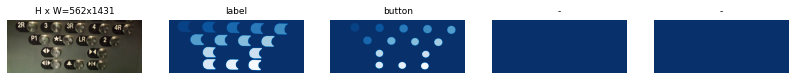

26
img height:  768
img width:  576
[1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1]


/home/abhi/CS/utcs/fri/final-project/elevator_panel.py:124: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  r=p['cy'], c=p['cx'], radius=p['r'])


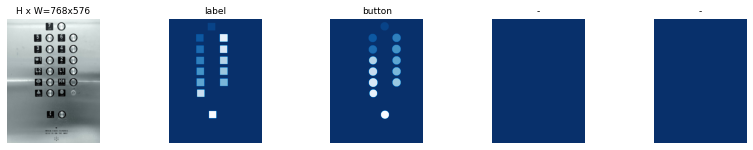

50
img height:  1408
img width:  990
[2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 2 1 2 2 1 1 1 2 1 2]


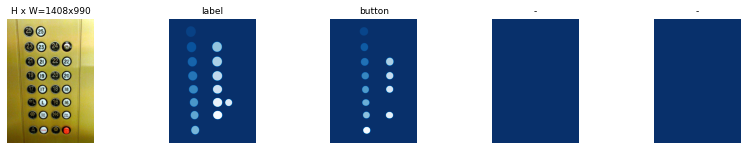

27
img height:  1362
img width:  2048
[1 2 1 2 1 2 1 2 1 2 1 2]


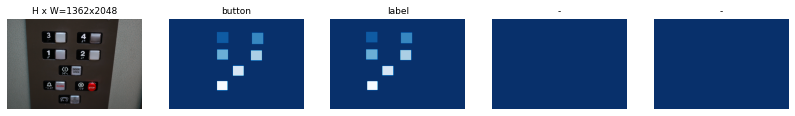

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)


img height:  1365
img width:  2048
[2 1 1 2]
image_id  56 /home/abhi/CS/utcs/fri/final-project/elevator_panels/train/36192994451_36a7ac6910_k.jpg
image                    shape: (1365, 2048, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1365, 2048, 4)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (4,)                  min:    1.00000  max:    2.00000  int32
bbox                     shape: (4, 4)                min:  461.00000  max: 1213.00000  int32


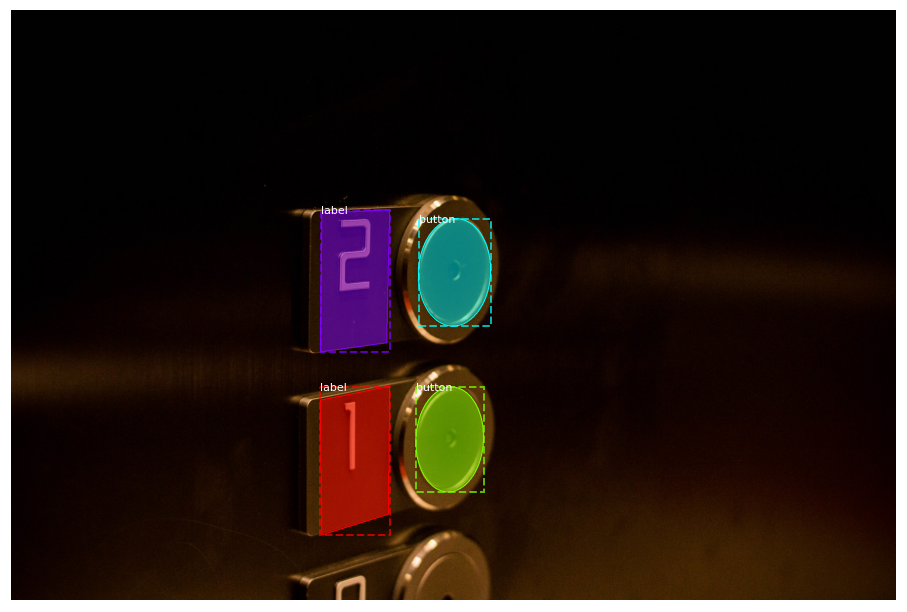

In [5]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)


img height:  2048
img width:  1296
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 2048.00000  float64
class_ids                shape: (28,)                 min:    1.00000  max:    2.00000  int32
bbox                     shape: (28, 4)               min:  394.00000  max:  963.00000  int32
mask                     shape: (1024, 1024, 28)      min:    0.00000  max:    1.00000  bool


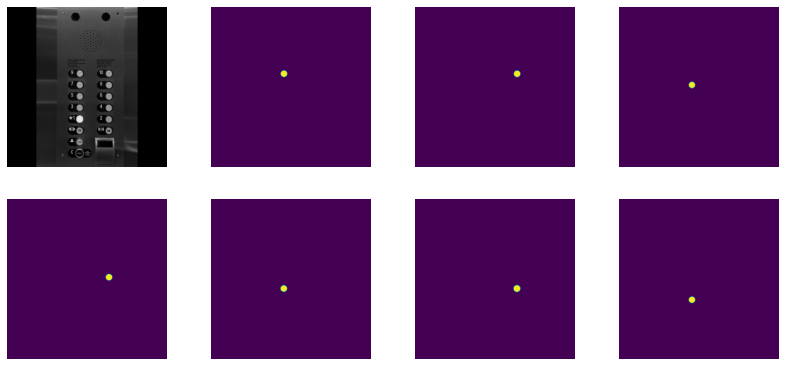

In [6]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

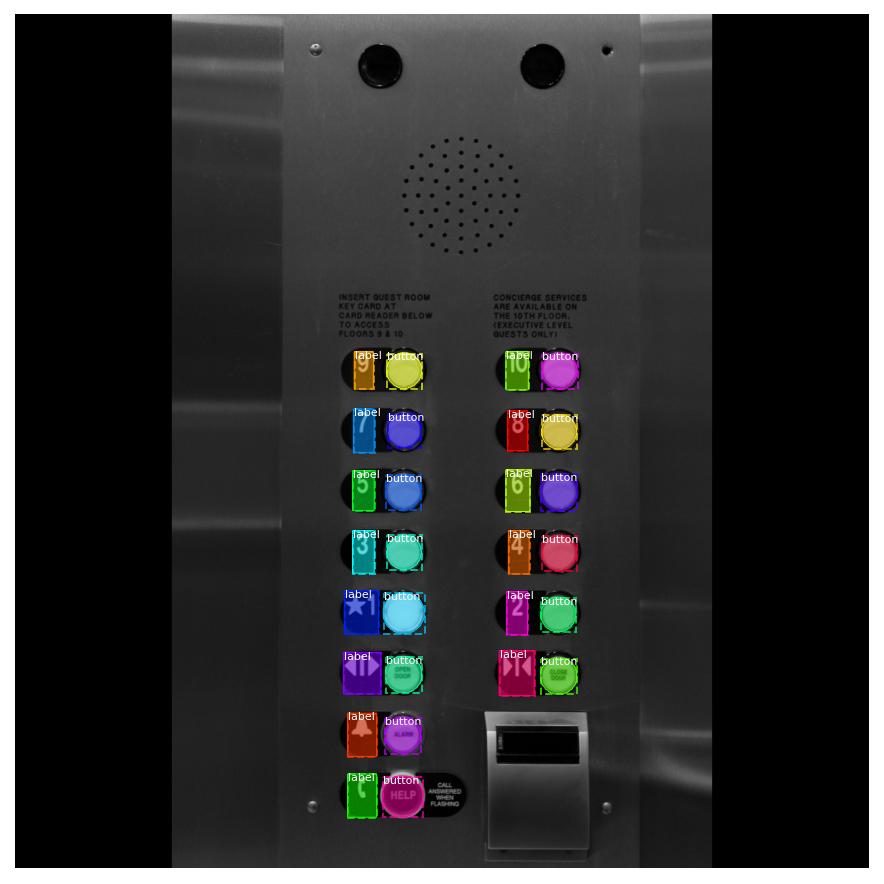

In [7]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

img height:  2048
img width:  1296
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/abhi/CS/utcs/fri/final-project/elevator_panel.py:124: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  r=p['cy'], c=p['cx'], radius=p['r'])
/home/abhi/CS/utcs/fri/final-project/env/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


mask                     shape: (56, 56, 28)          min:    0.00000  max:    1.00000  bool


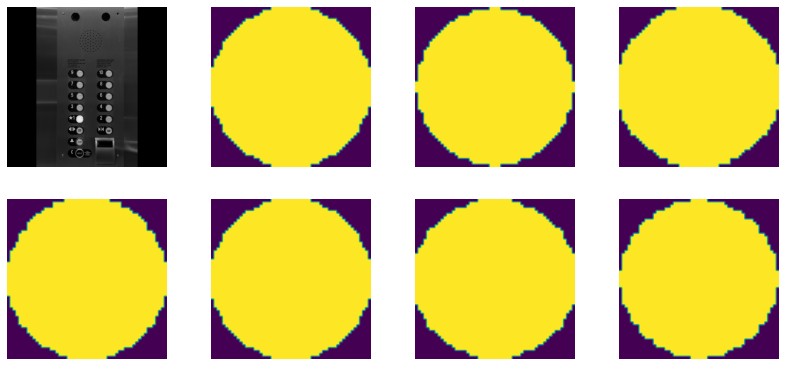

In [8]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

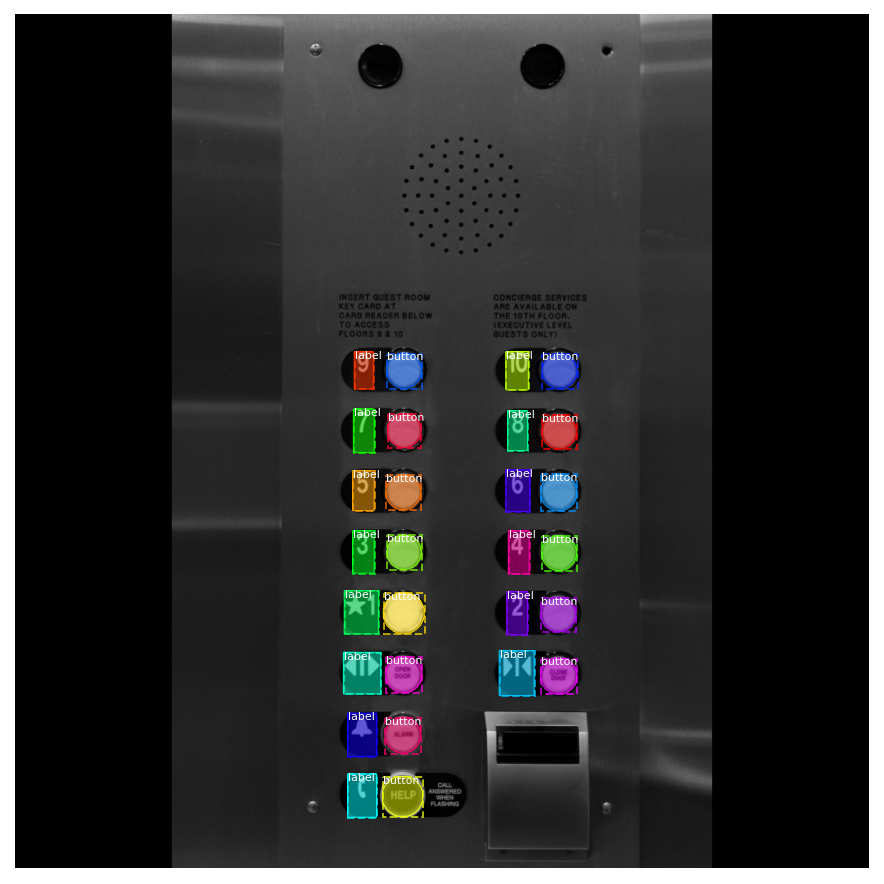

In [9]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)


In [10]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                         config.RPN_ANCHOR_RATIOS,
                                         backbone_shapes,
                                         config.BACKBONE_STRIDES,
                                         config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(
        anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))


Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


img height:  2560
img width:  1920
[2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1]
Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


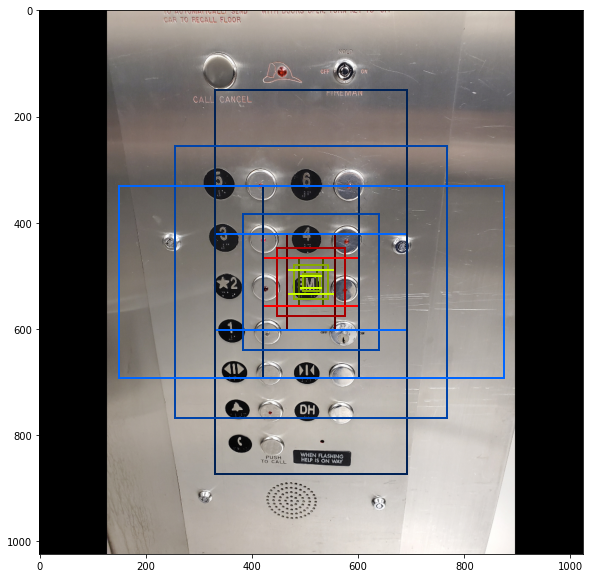

In [11]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    # sum of anchors of previous levels
    level_start = sum(anchors_per_level[:level])
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0],
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (
        center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level]
         [1] / config.RPN_ANCHOR_STRIDE**2)
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


In [16]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois,
    batch_size=4,
    detection_targets=True)


In [17]:
# # Uncomment to run the generator through a lot of images
# # to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)


In [18]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
# mrcnn_class_ids = mrcnn_class_ids[:,:,0]

img height:  640
img width:  480
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/abhi/CS/utcs/fri/final-project/elevator_panel.py:124: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  r=p['cy'], c=p['cx'], radius=p['r'])
/home/abhi/CS/utcs/fri/final-project/env/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
ERROR:root:Error processing image {'id': '769403832_3b7ff4267e_z.jpg', 'source': 'elevator_panel', 'path': '/home/abhi/CS/utcs/fri/final-project/elevator_panels/train/769403832_3b7ff4267e_z.jpg', 'width': 480, 'height': 640, 'polygons': [{'name': 'circle', 'cx': 145, 'cy': 144, 'r': 23}, {'name': 'circle', 'cx': 148, 'cy': 206, 'r': 23}, {'name': 'circle', 'cx': 152, 'cy': 261, 'r': 23}, {'name':

img height:  1536
img width:  2048
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/abhi/CS/utcs/fri/final-project/env/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
ERROR:root:Error processing image {'id': '16022980227_9d002fc69b_k.jpg', 'source': 'elevator_panel', 'path': '/home/abhi/CS/utcs/fri/final-project/elevator_panels/train/16022980227_9d002fc69b_k.jpg', 'width': 2048, 'height': 1536, 'polygons': [{'name': 'ellipse', 'cx': 629, 'cy': 330, 'rx': 49.806, 'ry': 50.773, 'theta': 0.02}, {'name': 'ellipse', 'cx': 657, 'cy': 528, 'rx': 44.914, 'ry': 44.914, 'theta': 0}, {'name': 'ellipse', 'cx': 677, 'cy': 701, 'rx': 43.721, 'ry': 39.056, 'theta': -0.514}, {'name': 'ellipse', 'cx': 694, 'cy': 846, 'rx': 48.82, 'ry': 41.02, 'theta': 2.474}, {'na

img height:  720
img width:  960
[1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 2 1 2]


/home/abhi/CS/utcs/fri/final-project/env/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
ERROR:root:Error processing image {'id': '215.jpg', 'source': 'elevator_panel', 'path': '/home/abhi/CS/utcs/fri/final-project/elevator_panels/train/215.jpg', 'width': 960, 'height': 720, 'polygons': [{'name': 'rect', 'x': 305, 'y': 337, 'width': 48, 'height': 41}, {'name': 'rect', 'x': 312, 'y': 387, 'width': 43, 'height': 43}, {'name': 'rect', 'x': 317, 'y': 439, 'width': 43, 'height': 38}, {'name': 'rect', 'x': 400, 'y': 435, 'width': 43, 'height': 40}, {'name': 'rect', 'x': 399, 'y': 386, 'width': 43, 'height': 40}, {'name': 'rect', 'x': 485, 'y': 384, 'width': 40, 'height': 37}, 

img height:  4032
img width:  3024
[3 3]


/home/abhi/CS/utcs/fri/final-project/env/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
ERROR:root:Error processing image {'id': 'IMG_1433.JPG', 'source': 'elevator_panel', 'path': '/home/abhi/CS/utcs/fri/final-project/elevator_panels/train/IMG_1433.JPG', 'width': 3024, 'height': 4032, 'polygons': [{'name': 'ellipse', 'cx': 1689, 'cy': 1617, 'rx': 165.348, 'ry': 201.65, 'theta': -2.841}, {'name': 'ellipse', 'cx': 1631, 'cy': 2634, 'rx': 144.893, 'ry': 183.443, 'theta': -2.561}], 'ids': [3, 3]}
Traceback (most recent call last):
  File "/home/abhi/CS/utcs/fri/final-project/mrcnn/model.py", line 1728, in data_generator
    rpn_rois, gt_class_ids, gt_boxes, gt_masks, confi

img height:  768
img width:  1024
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/home/abhi/CS/utcs/fri/final-project/env/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
ERROR:root:Error processing image {'id': '4524356479_7ab82dfcfe_b.jpg', 'source': 'elevator_panel', 'path': '/home/abhi/CS/utcs/fri/final-project/elevator_panels/train/4524356479_7ab82dfcfe_b.jpg', 'width': 1024, 'height': 768, 'polygons': [{'name': 'polygon', 'all_points_x': [182, 219, 231, 251, 248, 212, 199, 197, 179, 178], 'all_points_y': [240, 223, 226, 261, 272, 289, 287, 283, 255, 243]}, {'name': 'polygon', 'all_points_x': [315, 350, 364, 366, 382, 380, 376, 341, 334, 329, 310, 309], 'all_points_y': [181, 165, 167, 172, 205, 214, 219, 233, 233, 230, 195, 187]}, {'name': 'polyg

img height:  2048
img width:  1365
[2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1]


/home/abhi/CS/utcs/fri/final-project/env/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
ERROR:root:Error processing image {'id': '30548570633_54c2c83135_k.jpg', 'source': 'elevator_panel', 'path': '/home/abhi/CS/utcs/fri/final-project/elevator_panels/train/30548570633_54c2c83135_k.jpg', 'width': 1365, 'height': 2048, 'polygons': [{'name': 'ellipse', 'cx': 651, 'cy': 750, 'rx': 23, 'ry': 22, 'theta': 0}, {'name': 'ellipse', 'cx': 648, 'cy': 824, 'rx': 22.306, 'ry': 22.804, 'theta': 0.117}, {'name': 'ellipse', 'cx': 810, 'cy': 832, 'rx': 24, 'ry': 24, 'theta': 0}, {'name': 'ellipse', 'cx': 644, 'cy': 898, 'rx': 23, 'ry': 23, 'theta': 0}, {'name': 'ellipse', 'cx': 806, 'cy

IndexError: index 2 is out of bounds for axis 1 with size 2